In [55]:
import numpy as np
import pandas as pd
import re
import random
import email
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import coo_matrix, hstack

In [2]:
enron_data = pd.read_csv("enron-email-dataset/emails.csv", header=0, quoting=2)

In [3]:
enron_data.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
# filtering only those that contain 'sent' in file name (f.e _sent_mail, sent_mail, sent etc) 

enron_sent = enron_data[enron_data["file"].str.contains('sent').tolist()]

In [5]:
# extracting senders (there might me cases like "orgname/sender" but so far as we need only top 10 senders we are ok)

enron_sent = enron_sent.assign(sender=enron_sent["file"].map(lambda x: re.search("(.*)/.*sent", x).group(1)).values)
enron_sent.drop("file", axis=1, inplace=True)
enron_sent["sender"].value_counts().head(10)

mann-k          8926
kaminski-v      8644
dasovich-j      5366
germany-c       5128
shackleton-s    4407
jones-t         4123
bass-e          3030
lenhart-m       2759
beck-s          2674
symes-k         2649
Name: sender, dtype: int64

In [6]:
# mapping top senders' names to use later as label series
# we work only with top 10 senders

top_senders = enron_sent["sender"].value_counts().head(10).index.values
mapping = dict(zip(top_senders, range(10)))
print mapping

{'beck-s': 8, 'mann-k': 0, 'dasovich-j': 2, 'bass-e': 6, 'jones-t': 5, 'germany-c': 3, 'lenhart-m': 7, 'kaminski-v': 1, 'symes-k': 9, 'shackleton-s': 4}


In [7]:
# info

print enron_sent.shape
print enron_sent[enron_sent.sender.isin(top_senders)].shape

enron_sent = enron_sent[enron_sent.sender.isin(top_senders)]

(126846, 2)
(47706, 2)


In [8]:
# now let's take a look at random email

print enron_sent.iloc[random.randint(0, enron_sent.shape[0]), 0]

Message-ID: <28368401.1075846068730.JavaMail.evans@thyme>
Date: Mon, 12 Feb 2001 08:01:00 -0800 (PST)
From: kay.mann@enron.com
To: suzanne.adams@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Kay Mann
X-To: Suzanne Adams
X-cc: 
X-bcc: 
X-Folder: \Kay_Mann_June2001_4\Notes Folders\'sent mail
X-Origin: MANN-K
X-FileName: kmann.nsf

Please print.  Thanks,  Kay
---------------------- Forwarded by Kay Mann/Corp/Enron on 02/12/2001 04:00 
PM ---------------------------
From: Stuart Zisman@ECT on 02/12/2001 03:56 PM
To: Kay Mann/Corp/Enron@Enron
cc:  

Subject: 

Per your request, attached are the AES/Calvert docs

Stuart





In [9]:
# I use default email library just for simplicity. For real product I would use more complicated parsing tools or write my own
# We extract email artificials and content from raw text

def email_from_string(raw_email):
    msg = email.message_from_string(raw_email)
    
    content = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            content.append(part.get_payload())
            
    result = {}
    for key in msg.keys(): 
        result[key] = msg[key]
    result["content"] = ''.join(content)
    
    return result

In [10]:
enron_parsed = pd.DataFrame(list(map(email_from_string, enron_sent.message)))

In [11]:
enron_parsed.head(1)

,Bcc,Cc,Content-Transfer-Encoding,Content-Type,Date,From,Message-ID,Mime-Version,Subject,To,X-FileName,X-Folder,X-From,X-Origin,X-To,X-bcc,X-cc,content
0,NaN,NaN,7bit,text/plain; charset=us-ascii,"Fri, 9 Mar 2001 11:24:00 -0800 (PST)",eric.bass@enron.com,<17027752.1075840325838.JavaMail.evans@thyme>,1.0,Rebook - QU0663 Mirant,chance.rabon@enron.com,eric bass 6-25-02.PST,"\ExMerge - Bass, Eric\'Sent Mail",Eric Bass,BASS-E,Chance Rabon <Chance Rabon/ENRON@enronXgate>,,,\n---------------------- Forwarded by Eric Bas...


In [12]:
# cc and bcc stand for carbon copy and blind carbon copy and that may be useful for classification
# Also we might use "To" or any other metadata but I believe the idea of this work is to use simply "content" + "subject" 

enron_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47706 entries, 0 to 47705
Data columns (total 18 columns):
Bcc                          9259 non-null object
Cc                           9259 non-null object
Content-Transfer-Encoding    47706 non-null object
Content-Type                 47706 non-null object
Date                         47706 non-null object
From                         47706 non-null object
Message-ID                   47706 non-null object
Mime-Version                 47706 non-null object
Subject                      47706 non-null object
To                           47640 non-null object
X-FileName                   47706 non-null object
X-Folder                     47706 non-null object
X-From                       47706 non-null object
X-Origin                     47706 non-null object
X-To                         47706 non-null object
X-bcc                        47706 non-null object
X-cc                         47706 non-null object
content                   

In [13]:
#here we do simply two things: 1 remove numbers and 2 remove stowords using nltk stopwords corpus

def content_to_wordlist( content, remove_stopwords=False ):
    content = re.sub("[^a-zA-Z]"," ", content)
    words = content.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return ' '.join(words)

In [14]:
# enron_parsed['To'] = enron_parsed['To'].astype(str) # in case we want to use 'To' as information
data = pd.DataFrame(map(content_to_wordlist, 
                              enron_parsed[['Subject', 'content']].apply(lambda x: ' '.join(x), axis=1)), 
                          columns = ["content"])

In [15]:
data = data.assign(sender=enron_sent["sender"].values)
data = data.replace({'sender': mapping})
data.head()

,content,sender
0,rebook qu mirant forwarded by eric bass hou ec...,6
1,for your viewing pleasure forwarded by eric ba...,6
2,re fw christmas i think we are going to stay i...,6
3,re i didn t go either today is legs and lower ...,6
4,fwd the perils of limbo forwarded by eric bass...,6


In [16]:
# now we split data for training and test sets

data_train, data_test, y_train, y_test = train_test_split(data.content.values, data.sender.values, test_size=0.25)

In [17]:
# lets vectorize our content using default params

vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
X_train = vect.fit_transform(data_train)
X_test = vect.transform(data_test)

In [18]:
# 72k features!
X_train.shape

(35779, 72977)

In [32]:
# let's try to use simple feature selection using l1 regularization and default threshold

clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)

print X_train_new.shape

(35779, 1200)


In [31]:
# non linear methods? I skip GradientBoostingClassifier for now because of my laptop low productivity :(
# we will use cross validation with 3 folds for estimation

for classifier in [LinearSVC, LogisticRegression, SGDClassifier, RandomForestClassifier]:
    print cross_val_score(classifier(), X_train_new, y_train, cv=3).mean()

0.960703418097
0.944241299955
0.950781458876
0.930713990862


In [20]:
# let's try with the same vectorized data but using truncatedSVD as dimensionality redction method
# I set C=0.15 to reduce number of features ~100-200 

clf = LogisticRegression(C=0.15, penalty='l1')
clf.fit(X_train, y_train)

n_comp = np.sum(np.abs(clf.coef_) > 1e-4)
print n_comp

tsvd = TruncatedSVD(n_components = n_comp)
X_train_pca = tsvd.fit_transform(X_train)

for classifier in [LinearSVC, LogisticRegression, SGDClassifier, RandomForestClassifier]:
    print cross_val_score(classifier(), X_train_pca, y_train, cv=3).mean()

275
0.943486258801
0.933396612655
0.933537312386
0.899605635764


In [50]:
# lets try to set params for tf-idf vectorizer

vect = TfidfVectorizer(max_df=300, min_df=10)

X_train = vect.fit_transform(data_train)

print X_train.shape

(35779, 15280)


In [51]:
clf = LogisticRegression(C=0.15, penalty='l1')
clf.fit(X_train, y_train)

n_comp = np.sum(np.abs(clf.coef_) > 1e-4)
print n_comp

tsvd = TruncatedSVD(n_components = n_comp)
X_train_pca = tsvd.fit_transform(X_train)

for classifier in [LinearSVC, LogisticRegression, SGDClassifier, RandomForestClassifier]:
    print cross_val_score(classifier(), X_train_pca, y_train, cv=3).mean()

946
0.809088622453
0.782594114195
0.77890500545
0.817389117129


In [53]:
# we see it's hard to filter frequency of words manually
# let's fit min number of components for previous model 

vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
X_train = vect.fit_transform(data_train)

In [59]:
scores = []
for n_components in range(10, 200, 10):
    tsvd = TruncatedSVD(n_components = n_components)
    X_train_pca = tsvd.fit_transform(X_train)

    score = cross_val_score(LinearSVC(), X_train_pca, y_train, cv=3).mean()
    scores.append(score)
    print score

0.845979709902
0.908275341662
0.920516475224
0.924960174394
0.930409994131
0.93326066907
0.934350633018
0.936279030771
0.938123585143
0.937955898382
0.940051982896


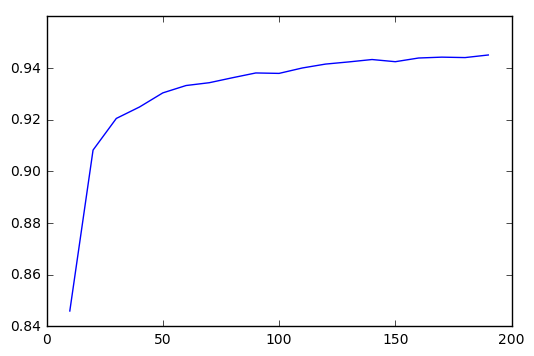

In [63]:
import matplotlib.pyplot as plt
plt.plot(range(10, 200, 10), scores)
plt.show()

In [33]:
#let's fit parameters for linear svm

tsvd = TruncatedSVD(n_components = 120)
X_train_pca = tsvd.fit_transform(X_train)

parameters = {'C':[0.1, 0.3, 0.5, 1, 3, 5, 10, 30]}
clf = GridSearchCV(LinearSVC(), parameters)
clf.fit(X_train_pca, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.3, 0.5, 1, 3, 5, 10, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [34]:
clf.grid_scores_

[mean: 0.92918, std: 0.00164, params: {'C': 0.1},
 mean: 0.93415, std: 0.00186, params: {'C': 0.3},
 mean: 0.93619, std: 0.00155, params: {'C': 0.5},
 mean: 0.93832, std: 0.00100, params: {'C': 1},
 mean: 0.94038, std: 0.00145, params: {'C': 3},
 mean: 0.94103, std: 0.00165, params: {'C': 5},
 mean: 0.94108, std: 0.00173, params: {'C': 10},
 mean: 0.94131, std: 0.00156, params: {'C': 30}]

In [39]:
# finally let's train the model on the test data and do some model evaluation

tsvd = TruncatedSVD(n_components = 120)
X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)

clf = LinearSVC()
clf.fit(X_train_pca, y_train)

print metrics.accuracy_score(y_test, clf.predict(X_test_pca))

0.938878175568


In [44]:
confusion_matrix(y_test, clf.predict(X_test_pca))

array([[2166,   11,    9,   25,    2,    4,    6,   37,    7,    1],
       [   4, 2196,    6,   15,    2,    3,    8,    1,    2,    0],
       [   8,   18, 1240,   15,    0,    3,    1,   52,    2,    1],
       [  14,   11,   11, 1154,    2,    6,    8,   38,    5,    3],
       [   9,    8,    0,    9, 1005,   27,    2,    3,    3,    0],
       [   8,    6,    9,   11,   22,  940,    3,   33,    0,    0],
       [   6,   14,   10,   28,    1,    2,  624,   28,    3,    1],
       [   5,    4,   14,   23,    0,    9,   24,  623,    0,    4],
       [   0,    1,    4,    7,    0,    2,    0,    4,  648,    0],
       [   5,    4,    4,   10,    0,    2,    1,   13,    2,  602]])

In [45]:
print(classification_report(y_test, clf.predict(X_test_pca), target_names=top_senders))

              precision    recall  f1-score   support

      mann-k       0.97      0.96      0.96      2268
  kaminski-v       0.97      0.98      0.97      2237
  dasovich-j       0.95      0.93      0.94      1340
   germany-c       0.89      0.92      0.91      1252
shackleton-s       0.97      0.94      0.96      1066
     jones-t       0.94      0.91      0.93      1032
      bass-e       0.92      0.87      0.90       717
   lenhart-m       0.75      0.88      0.81       706
      beck-s       0.96      0.97      0.97       666
     symes-k       0.98      0.94      0.96       643

 avg / total       0.94      0.94      0.94     11927



I believe we get these high scores with that small amount of features because of names/email addresses encoded in email raw content. But there were no bans fot this:) Let's try to add some email metadata:

In [14]:
# we add To and Bcc/cc features from mail metadata to see if it will increase our accuracy:

enron_parsed['To'] = enron_parsed['To'].astype(str) 
data = pd.DataFrame(map(content_to_wordlist, enron_parsed[['Subject', 'content', 'To']].apply(lambda x: ' '.join(x), axis=1)), 
                          columns = ["content"])

In [22]:
data['bcc'] = enron_parsed['Bcc'].isnull().astype(int)

data = data.assign(sender=enron_sent["sender"].values)
data = data.replace({'sender': mapping})
data.head()

,content,bcc,sender
0,rebook qu mirant forwarded by eric bass hou ec...,1,6
1,for your viewing pleasure forwarded by eric ba...,1,6
2,re fw christmas i think we are going to stay i...,1,6
3,re i didn t go either today is legs and lower ...,1,6
4,fwd the perils of limbo forwarded by eric bass...,1,6


In [61]:
data_train, data_test, y_train, y_test = train_test_split(data[['content', 'bcc']], data['sender'], test_size=0.25)

vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
X_train = vect.fit_transform(data_train.content)
X_test = vect.transform(data_test.content)

X_train = hstack([coo_matrix(X_train), coo_matrix(data_train.bcc).transpose()])
X_test = hstack([coo_matrix(X_test), coo_matrix(data_test.bcc).transpose()])

In [62]:
print X_train.shape
print X_test.shape

(35779, 73329)
(11927, 73329)


In [71]:
tsvd = TruncatedSVD(n_components = 120)
X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)

clf = LinearSVC()
clf.fit(X_train_pca, y_train)

print metrics.accuracy_score(y_test, clf.predict(X_test_pca))
print metrics.f1_score(y_test, clf.predict(X_test_pca), average="weighted")

0.958749056762
0.958700649629


In [64]:
confusion_matrix(y_test, clf.predict(X_test_pca))

array([[2241,    3,    4,    6,    6,    8,    1,    8,    5,    0],
       [   0, 2147,   11,    3,    0,    1,    2,    2,    2,    0],
       [   2,    0, 1303,    8,    1,    6,    1,   11,    1,    2],
       [   5,   11,    6, 1215,    3,    0,    1,   11,    2,    2],
       [   4,    5,    4,    8, 1049,   54,    0,    2,    2,    1],
       [   9,    3,    8,   10,   57,  874,    2,   16,    3,    3],
       [   3,    2,    1,   11,    0,    2,  690,   36,    3,    0],
       [   1,    1,    8,    9,    2,    3,   33,  631,    1,    5],
       [   0,    5,    2,    3,    1,    4,    0,    4,  655,    1],
       [   6,    3,    6,    8,    0,    5,    2,    3,    1,  621]])

In [65]:
print(classification_report(y_test, clf.predict(X_test_pca), target_names=top_senders))

              precision    recall  f1-score   support

      mann-k       0.99      0.98      0.98      2282
  kaminski-v       0.98      0.99      0.99      2168
  dasovich-j       0.96      0.98      0.97      1335
   germany-c       0.95      0.97      0.96      1256
shackleton-s       0.94      0.93      0.93      1129
     jones-t       0.91      0.89      0.90       985
      bass-e       0.94      0.92      0.93       748
   lenhart-m       0.87      0.91      0.89       694
      beck-s       0.97      0.97      0.97       675
     symes-k       0.98      0.95      0.96       655

 avg / total       0.96      0.96      0.96     11927



So adding 'To' and 'Bcc' leads to slightly better result in classification. Of course to increase accuracy we need to do better preprocessing of raw emails f.e. to extract information from content of the mail (email addresses, references, forwards, names etc) but still we score a good one here. Unfortunately I was on able to run GradientBoostingClassifier, XGBoost models on this machine